# Setup Environment and Read Data

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
import copy
from tqdm import trange,tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

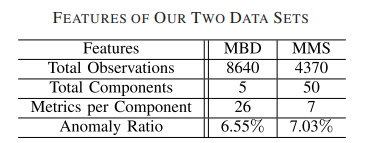

In [ ]:
DRIVE = "drive/MyDrive/Colab Notebooks/ELTE/DSLAB/dataset/"
DATASET = DRIVE + "MBD.csv"
TOPOLOGY = DRIVE + "MBD_topology.pk"
NUM_OF_COMPONENTS = 5

data = pd.read_csv(DATASET, header=[0,1])
true_anomalies = data['label'].values

metric = data.drop(['date', 'label'], axis = 1)
metric.columns.names = ['host','metric']
tempm = metric.swaplevel('metric','host',axis=1).stack()
tempm = (tempm-tempm.mean())/(tempm.std())
metric = tempm.unstack().swaplevel('metric','host',axis=1).stack().unstack()
metric_tensor = torch.tensor(metric.values, dtype=torch.float32)

with open(TOPOLOGY, 'rb') as f:
    edge_index = pickle.load(f)

<ipython-input-29-49ccc0f6c925>:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  metric = data.drop(['date', 'label'], axis = 1)
<ipython-input-29-49ccc0f6c925>:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tempm = metric.swaplevel('metric','host',axis=1).stack()
<ipython-input-29-49ccc0f6c925>:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  metric = tempm.unstack().swaplevel('metric','host',axis=1).stack().unstack()


In [ ]:
metric

host              R740-3-1                                               \
metric cpu.mean_usage_idle cpu.mean_usage_iowait cpu.mean_usage_softirq   
0                 1.297715             -0.632874              -0.703865   
1                 1.386064             -0.747534              -0.703948   
2                -1.239377             -0.797039              -0.664087   
3                -1.644451             -0.835336              -0.703936   
4                -1.643598             -0.838276              -0.703845   
...                    ...                   ...                    ...   
8635              1.438887             -0.821302              -0.703730   
8636              1.451945             -0.836429              -0.695918   
8637              1.440971             -0.827184              -0.672011   
8638              1.437342             -0.821685              -0.664070   
8639              1.451885             -0.833846              -0.743528   

host                                                                     \
metric cpu.mean_usage_system cpu.mean_usage_user disk.mean_used_percent   
0                  -0.812009           -0.960151              -1.912235   
1                  -0.834344           -0.958793              -1.912233   
2                  -0.693319            2.380106              -1.912231   
3                  -0.719389            2.927902              -1.912229   
4                  -0.687902            2.928635              -1.912227   
...                      ...                 ...                    ...   
8635               -0.792337           -0.955754              -1.911606   
8636               -0.784464           -0.956904              -1.911604   
8637               -0.832834           -0.950063              -1.911602   
8638               -0.765072           -0.954403              -1.911601   
8639               -0.800240           -0.958342              -1.911599   

host                                                                  \
metric diskio.io_time diskio.mean_iops_in_progress diskio.read_speed   
0           -0.125818                    -0.394307         -0.484756   
1           -0.149738                    -0.426539         -0.484756   
2           -0.137616                    -0.426539         -0.483687   
3           -0.146556                    -0.422957         -0.484743   
4           -0.174985                    -0.412214         -0.484756   
...               ...                          ...               ...   
8635        -0.226616                    -0.462351         -0.484756   
8636        -0.233937                    -0.462351         -0.484756   
8637        -0.230273                    -0.462351         -0.484756   
8638        -0.235003                    -0.462351         -0.484756   
8639        -0.232342                    -0.462351         -0.484756   

host                       ...      R740-3-5                         \
metric diskio.write_speed  ... mem.mean_free net.recieved  net.sent   
0               -0.549166  ...     -0.600163    -0.729554  0.131946   
1               -0.549179  ...     -0.496413    -0.729449  0.131897   
2               -0.549084  ...     -0.499616    -0.728573  0.131962   
3               -0.548879  ...     -0.503554    -0.727601  0.957520   
4               -0.549193  ...     -0.552925    -0.730687  0.133904   
...                   ...  ...           ...          ...       ...   
8635            -0.549426  ...     -0.640990     0.278332 -0.135095   
8636            -0.549877  ...     -0.642823     0.020555 -0.657424   
8637            -0.549508  ...     -0.625552     0.441609  0.009106   
8638            -0.548154  ...     -0.654699    -0.484553  0.898695   
8639            -0.549357  ...     -0.663206    -0.728644  0.732069   

host                                                      \
metric netstat.mean_tcp_time_wait processes.mean_blocked   
0                        3.001606               0.021189   
1      

# Preprocess the Dataset

In [ ]:
# Scale the values of the input metrics
scaler = MinMaxScaler()
metric_scaled = scaler.fit_transform(metric)
metric_tensor = torch.tensor(metric_scaled, dtype=torch.float32)
metric_scaled = pd.DataFrame(metric_scaled, index=metric.index, columns=metric.columns)
metric_scaled

host              R740-3-1                                               \
metric cpu.mean_usage_idle cpu.mean_usage_iowait cpu.mean_usage_softirq   
0                 0.950674              0.196214               0.038462   
1                 0.977175              0.088424               0.038382   
2                 0.189643              0.041885               0.077036   
3                 0.068136              0.005882               0.038393   
4                 0.068392              0.003118               0.038481   
...                    ...                   ...                    ...   
8635              0.993020              0.019076               0.038593   
8636              0.996937              0.004855               0.046169   
8637              0.993645              0.013547               0.069352   
8638              0.992556              0.018716               0.077052   
8639              0.996919              0.007283               0.000000   

host                                                                     \
metric cpu.mean_usage_system cpu.mean_usage_user disk.mean_used_percent   
0                   0.003521            0.001633               0.024794   
1                   0.002268            0.001958               0.024931   
2                   0.010180            0.799099               0.025091   
3                   0.008718            0.929881               0.025243   
4                   0.010484            0.930056               0.025374   
...                      ...                 ...                    ...   
8635                0.004625            0.002683               0.070769   
8636                0.005066            0.002408               0.070892   
8637                0.002353            0.004042               0.071016   
8638                0.006154            0.003006               0.071135   
8639                0.004181            0.002065               0.071258   

host                                                                  \
metric diskio.io_time diskio.mean_iops_in_progress diskio.read_speed   
0            0.139161                     0.004854          0.000000   
1            0.109986                     0.002555          0.000000   
2            0.124771                     0.002555          0.001839   
3            0.113868                     0.002810          0.000022   
4            0.079193                     0.003577          0.000000   
...               ...                          ...               ...   
8635         0.016220                     0.000000          0.000000   
8636         0.007291                     0.000000          0.000000   
8637         0.011761                     0.000000          0.000000   
8638         0.005991                     0.000000          0.000000   
8639         0.009237                     0.000000          0.000000   

host                       ...      R740-3-5                         \
metric diskio.write_speed  ... mem.mean_free net.recieved  net.sent   
0                0.000203  ...      0.026584     0.000183  0.098977   
1                0.000200  ...      0.055531     0.000192  0.098971   
2                0.000221  ...      0.054637     0.000267  0.098979   
3                0.000264  ...      0.053539     0.000350  0.198149   
4                0.000197  ...      0.039764     0.000086  0.099212   
...                   ...  ...           ...          ...       ...   
8635             0.000148  ...      0.015193     0.086387  0.066898   
8636             0.000052  ...      0.014681     0.064340  0.004154   
8637             0.000131  ...      0.019500     0.100352  0.084221   
8638             0.000418  ...      0.011368     0.021138  0.191083   
8639             0.000163  ...      0.008994     0.000261  0.171067   

host                                                      \
metric netstat.mean_tcp_time_wait processes.mean_blocked   
0                        0.334012               0.086957   
1      

Scaled

In [ ]:
# create train and test dataloaders
metric_scaled.interpolate(inplace=True)
metric_scaled.bfill(inplace=True)
metric_tensor = metric_scaled.values
sequence_length = 30
sequences = [metric_tensor[i:i + sequence_length].reshape(sequence_length, NUM_OF_COMPONENTS, -1) for i in range(metric_tensor.shape[0] - sequence_length + 1)]

train_data, temp_data = train_test_split(sequences, test_size=0.3, random_state=42) # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42) # 50% of temp for val and test

batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Non-Scaled

In [ ]:
# create train and test dataloaders
metric.interpolate(inplace=True)
metric.bfill(inplace=True)
metric_tensor = metric.values
sequence_length = 30
sequences = [metric_tensor[i:i + sequence_length].reshape(sequence_length, NUM_OF_COMPONENTS, -1) for i in range(metric_tensor.shape[0] - sequence_length + 1)]

train_data, temp_data = train_test_split(sequences, test_size=0.3, random_state=42) # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42) # 50% of temp for val and test

batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Network

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.linear1(x)
        x = self.LeakyReLU(x)
        x = self.linear2(x)
        x = self.LeakyReLU(x)

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.linear2(x)
        x = self.LeakyReLU(x)
        x = self.linear1(x)
        x = self.LeakyReLU(x)

        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=200, latent_dim=26, device=device):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim).to(device)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim).to(device)

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [ ]:
model = VAE(input_dim=26).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
def save_model(model):
    model_state = {
        'input_dim':26,
        'latent_dim':26,
        'hidden_dim':200,
        'state_dict':model.state_dict()
    }
    torch.save(model_state,'vae.pth')

# Train

In [ ]:
torch.cuda.empty_cache()

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

# SPO optimizer - optuna
# bayesian hyperparameter tuning
# grid search - slow for DL

def train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []

    early_stop_tolerant_count = 0
    early_stop_tolerant = 10
    best_loss = float('inf')
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        model.train()
        for batch_idx, x in enumerate(train_loader):
            x = x.to(device).type(torch.float32)

            # zero the parameter gradients
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)

            # forward + loss + backward + optimize
            loss = loss_fn(x, x_hat, mean, log_var)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)  # Divide by number of batches
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch_idx, x in enumerate(val_loader):
                x = x.to(device).type(torch.float32)

                x_hat, mean, log_var = model(x)

                loss = loss_fn(x, x_hat, mean, log_var)
                valid_loss += loss.item()

        valid_loss /= len(val_loader)  # Divide by number of batches
        val_losses.append(valid_loss)

        scheduler.step(valid_loss)

        early_stop_tolerant_count += 1
        if valid_loss < best_loss:
            early_stop_tolerant_count = 0
            best_loss = valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if early_stop_tolerant_count >= early_stop_tolerant:
            break

        print(f"Epoch {epoch:04d}: train loss {train_loss:.4f}, valid loss {valid_loss:.4f}")
        save_model(model)

    print('Finished Training')
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, loss_function, scheduler, num_epochs=15)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0000: train loss 119904.4804, valid loss 107506.5245
Epoch 0001: train loss 112748.2512, valid loss 106028.1249
Epoch 0002: train loss 111024.1566, valid loss 103678.8337
Epoch 0003: train loss 108669.9757, valid loss 101762.5807
Epoch 0004: train loss 106585.8359, valid loss 99174.5565
Epoch 0005: train loss 102721.3032, valid loss 95338.8220
Epoch 0006: train loss 99923.4930, valid loss 93158.9183
Epoch 0007: train loss 98352.1140, valid loss 92225.5755
Epoch 0008: train loss 97722.6643, valid loss 91792.5613
Epoch 0009: train loss 97373.2231, valid loss 91504.3789
Epoch 0010: train loss 97151.5486, valid loss 91326.3417
Epoch 0011: train loss 97001.5598, valid loss 91205.8856
Epoch 0012: train loss 96855.9873, valid loss 91043.6362
Epoch 0013: train loss 96747.0482, valid loss 90968.5442
Epoch 0014: train loss 96661.3297, valid loss 90863.3236
Finished Training


# Evaluate

In [ ]:
def interpret(model, data_loader, nodes_num, sampling_num=5, delay=5):
        model.eval()

        scores_sum = []
        outputs = []

        for (i,ts_batch) in enumerate(tqdm(data_loader)):
            ts_batch = ts_batch.to(device).type(torch.float32)
            x_hat, mean, log_var = model(ts_batch)

            sample_scores_sum = []

            for j in range(sampling_num):
                error_origin = torch.div((x_hat - ts_batch) ** 2, log_var.exp()) + log_var

                sample_score_sum = torch.sum(error_origin, 3)

                sample_scores_sum.append(sample_score_sum)

            score_sum = torch.mean(torch.stack(sample_scores_sum,3),3)
            #print(score_sum)

            scores_sum.append(score_sum.data.cpu().numpy())
            outputs.append(mean.data.cpu().numpy())

        scores_sum = np.concatenate(scores_sum)
        #print(scores_sum)
        outputs = np.concatenate(outputs)

        scores_argsort = np.argsort(-scores_sum)

        return scores_sum, outputs, scores_argsort

In [ ]:
scores_sum, outputs, scores_argsort = interpret(model, test_loader, NUM_OF_COMPONENTS)

100%|██████████| 41/41 [00:00<00:00, 433.16it/s]


In [ ]:
threshold = np.percentile(scores_sum, 95)
anomalies = scores_sum > threshold

print("Anomaly Indices:", np.where(anomalies)[0])

Anomaly Indices: [   0    0    0 ... 1291 1291 1291]


In [ ]:
print(threshold)

52.588352


In [ ]:
print(len(np.where(anomalies)[0]))

9690


In [ ]:
print(len(scores_sum))

1292


In [ ]:
# Create a binary array with the same length as true_anomalies
predicted_anomalies = np.zeros_like(true_anomalies, dtype=bool)

# Flatten anomalies to match the shape of predicted_anomalies
flattened_anomalies = anomalies.any(axis=(1, 2)) #Checks for any anomaly across components and timestamps for each sequence in test_data

# Create anomaly_indices to match true_anomalies length
anomaly_indices = np.arange(len(true_anomalies))
anomaly_indices = anomaly_indices[metric.shape[0] - len(sequences): metric.shape[0] - len(sequences) + len(flattened_anomalies)]

# Reshape anomalies to have a single column
reshaped_anomalies = flattened_anomalies.reshape(-1, 1)

# Now assign the anomaly values (True/False) using boolean indexing
predicted_anomalies[anomaly_indices] = reshaped_anomalies

# Calculate the F1 score
f1 = f1_score(true_anomalies, predicted_anomalies)

print(f"F1 Score: {f1}")

F1 Score: 0.0638169777242625


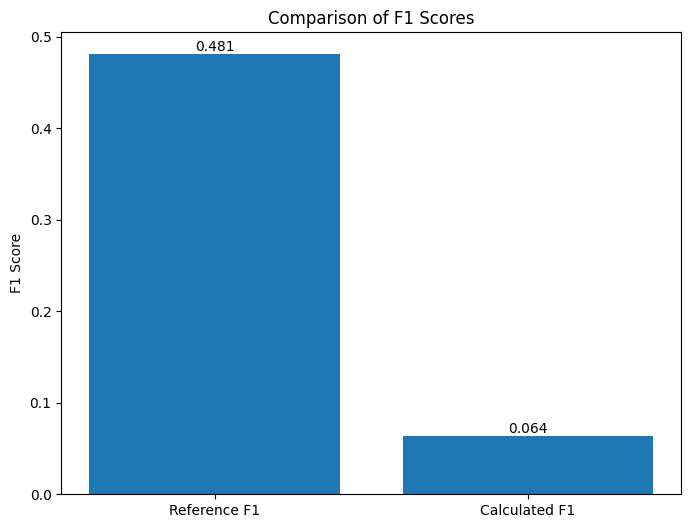

In [ ]:
reference_f1 = 0.481

plt.figure(figsize=(8, 6))
bars = plt.bar(['Reference F1', 'Calculated F1'], [reference_f1, f1])

plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.show()